# Analysis of human behavior across scenarios

**The purpose of this notebook is to:** 
* Apply preprocessing to human behavioral data
* Visualize distribution and compute summary statistics over **human** physical judgments
* Output CSV that can be re-loaded into R notebook for statistical modeling & fancy visualizations

**This notebook depends on:**
* Running `./generate_dataframes.py` (INTERNAL USE ONLY)
* Running `./upload_results.py` (INTERNAL USE ONLY)
* Running `./download_results.py` (PUBLIC USE)

## setup

#### Load packages

In [9]:
import os
import sys
import urllib, io

sys.path.append('./analysis_helpers')
from importlib import reload
from analysis_helpers import *

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

from tqdm.notebook import tqdm

import  matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-white')

import seaborn as sns

%matplotlib inline
import scipy.stats
import random

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

#### options

In [10]:
# display all columns
pd.set_option('display.max_columns', None)

# seaborn plotting themes
sns.set_context('talk')
sns.set_style("whitegrid")

#### set up paths and directories

In [11]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
## add helpers to python path
if os.path.join(analysis_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(analysis_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

### load in data

In [12]:
from experiment_meta import *
HEM = pd.DataFrame(NEURIPS2021_EXPS) # HEM = "human experiment metadata"
HEM

,study,bucket_name,stim_version,iterationName
0,dominoes_pilot,human-physics-benchmarking-dominoes-pilot,production_1,production_1_testing
1,collision_pilot,human-physics-benchmarking-collision-pilot,production_2,production_2_testing
2,towers_pilot,human-physics-benchmarking-towers-pilot,production_2,production_2_testing
3,linking_pilot,human-physics-benchmarking-linking-pilot,production_2,production_2_testing
4,containment_pilot,human-physics-benchmarking-containment-pilot,production_2,production_2_testing
5,rollingsliding_pilot,human-physics-benchmarking-rollingsliding-pilot,production_2,production_2_testing
6,drop_pilot,human-physics-benchmarking-drop-pilot,production_2,production_2_testing
7,clothiness_pilot,human-physics-benchmarking-clothiness-pilot,production_2,production_2_testing


In [13]:
## get paths to all human response data
data_paths = [os.path.join(csv_dir,'humans',i) for i in os.listdir(os.path.join(csv_dir,'humans'))]
resp_paths = [i for i in data_paths if i.split('/')[-1].split('-')[0]=='human_responses']
assert len(resp_paths)==8

In [14]:
## load in example dataframe
exp_ind = 0
d = pd.concat([pd.read_csv(p) for p in resp_paths])

## some utility vars
d['scenarioName'] = d['study'].apply(lambda x:x.split('_')[0])
# colnames_with_variable_entries = [col for col in sorted(d.columns) if len(np.unique(d[col]))>1]
colnames = ['scenarioName','study','gameID','trialNum','prolificIDAnon','stim_ID','response','target_hit_zone_label','correct','choices','rt']
# colnames = ['gameID','trialNum','stim_ID','response','target_hit_zone_label','correct','choices','rt']

## subset dataframe by colnames of interest
_D = d[colnames]

## preprocess RTs (subtract 2500ms presentation time, log transform)
_D = _D.assign(RT = _D['rt'] - 2500) 
_D = _D.assign(logRT = np.log(_D['RT']))
_D = _D.drop(columns=['rt'],axis=1)

## convert responses to boolean
binary_mapper = {'YES':True, 'NO':False}
_D = _D.assign(responseBool = _D['response'].apply(lambda x: binary_mapper[x]), axis=0)

# print('Currently analyzing the {} experiment.'.format(scenarioName))

### Data exclusion criteria (from `preregistration_neurips2021.md`)

 Data from an entire experimental session will be excluded if the responses:
 * contain a sequence with unusually long streak, defined as occurring less than 2.5% of the time under random responding
 * contain a sequence of at least 24 trials alternating "yes" and "no" responses
 * are correct for fewer than 4 out of 10 familiarization trials (i.e., 30% correct or lower)
 * the mean accuracy for that participant is below 3 standard deviations below the median accuracy across all participants \for that scenario
 * the mean log-transformed response time for that participant is 3 standard deviations above the median log-transformed response time across all participants for that scenario
 
Excluded sessions will be flagged. Flagged sessions will not be included in the main analyses. We will also conduct our planned analyses with the flagged sessions included to investigate the extent to which the outcomes of the main analyses change when these sessions are included. Specifically, we will fit a statistical model to all sessions and estimate the effect of a session being flagged on accuracy. 

In [15]:
from analysis_helpers import *
D = apply_exclusion_criteria(_D)

## Visualize distribution and compute summary statistics over human physical judgments



### Human accuracy across participants for each stimulus
We will analyze accuracy for each stimulus by computing the proportion of correct responses across all participants who viewed that stimulus. 



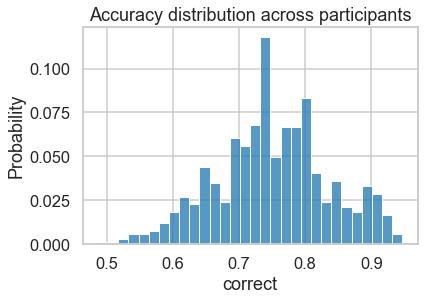

In [16]:
Dacc = D.groupby('prolificIDAnon').agg({'correct':np.mean})
h = sns.histplot(data=Dacc, x='correct', bins=30, stat='probability')
t = plt.title('Accuracy distribution across participants')

In [17]:
def bootstrap_mean(D, col = 'correct', nIter=1000):
    bootmean = []
    for currIter in np.arange(nIter):
        bootD = D.sample(n=len(D),random_state=currIter, replace=True)            
        bootmean.append(np.mean(bootD[col].values))
    return bootmean

In [19]:
bootmeans = bootstrap_mean(Dacc, col='correct', nIter=1000)
lb = np.percentile(bootmeans,2.5)
ub = np.percentile(bootmeans,97.5)
print('The observed mean accuracy is {}.'.format(np.round(Dacc['correct'].mean(),3)))
print('95% CI: [{},{}].'.format(lb.round(3),ub.round(3)))

The observed mean accuracy is 0.75.
95% CI: [0.744,0.757].


### Human accuracy across stimuli for each participant
We will analyze accuracy for each participant by computing the proportion of correct responses across all stimuli. 



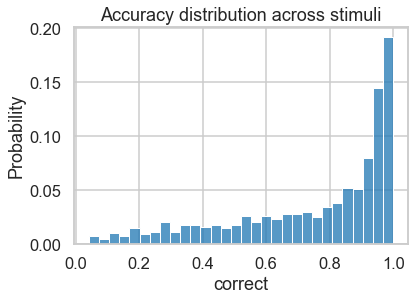

In [20]:
Dacc = D.groupby('stim_ID').agg({'correct':np.mean})
h = sns.histplot(data=Dacc, x='correct', bins=30, stat='probability')
t = plt.title('Accuracy distribution across stimuli')

### Human accuracy by scenario
We will fit human responses across all scenarios with a mixed-effects logistic regression model, including scenario as a fixed effect and participants and individual stimuli as random effects.

In [21]:
D

,scenarioName,study,gameID,trialNum,prolificIDAnon,stim_ID,response,target_hit_zone_label,correct,choices,RT,logRT,responseBool,axis
0,collision,collision_pilot,0237-0c7e8936-6614-4533-96e5-bbb7721c2b1f,0,954nmkfmwh4y94iiipid4559,pilot_it2_collision_assorted_targets_box_1_dis...,NO,False,True,"['NO', 'YES']",1711.510,7.445131,False,0
1,collision,collision_pilot,0237-0c7e8936-6614-4533-96e5-bbb7721c2b1f,1,954nmkfmwh4y94iiipid4559,pilot_it2_collision_simple_box_1_dis_1_occ_000...,YES,True,True,"['NO', 'YES']",1398.110,7.242877,True,0
2,collision,collision_pilot,0237-0c7e8936-6614-4533-96e5-bbb7721c2b1f,2,954nmkfmwh4y94iiipid4559,pilot_it2_collision_non-sphere_box_0001_img,YES,True,True,"['NO', 'YES']",1378.480,7.228737,True,0
3,collision,collision_pilot,0237-0c7e8936-6614-4533-96e5-bbb7721c2b1f,3,954nmkfmwh4y94iiipid4559,pilot_it2_collision_non-sphere_tdw_1_dis_1_occ...,NO,False,True,"['NO', 'YES']",1731.105,7.456515,False,0
4,collision,collision_pilot,0237-0c7e8936-6614-4533-96e5-bbb7721c2b1f,4,954nmkfmwh4y94iiipid4559,pilot_it2_collision_assorted_targets_box_1_dis...,YES,True,True,"['NO', 'YES']",1821.545,7.507440,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15295,towers,towers_pilot,1976-7e6661d3-4c2c-4cce-8db4-95349e6088da,145,95cndn9kpphpdkinhpcnprcp,pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_o...,NO,False,True,"['YES', 'NO']",3711.570,8.219210,False,0
15296,towers,towers_pilot,1976-7e6661d3-4c2c-4cce-8db4-95349e6088da,146,95cndn9kpphpdkinhpcnprcp,pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_t...,YES,True,True,"['YES', 'NO']",1433.085,7.267585,True,0
15297,towers,towers_pilot,1976-7e6661d3-4c2c-4cce-8db4-95349e6088da,147,95cndn9kpphpdkinhpcnprcp,pilot_towers_nb4_fr015_SJ000_gr-01_mono1_dis1_...,YES,True,True,"['YES', 'NO']",1567.540,7.357263,True,0
15298,towers,towers_pilot,1976-7e6661d3-4c2c-4cce-8db4-95349e6088da,148,95cndn9kpphpdkinhpcnprcp,pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_t...,YES,True,True,"['YES', 'NO']",1473.855,7.295637,True,0


@Felix: I'm not certain whether the following models are what we want

In [22]:
from pymer4.models import Lmer

In [64]:
model = Lmer('correct ~ scenarioName + (1|prolificIDAnon) + (1|stim_ID)',data = D, family='binomial')

In [65]:
model.fit()

Model failed to converge with max|grad| = 0.0034171 (tol = 0.001, component 1) 

Formula: correct~scenarioName+(1|prolificIDAnon)+(1|stim_ID)

Family: binomial	 Inference: parametric

Number of observations: 103350	 Groups: {'stim_ID': 1200.0, 'prolificIDAnon': 662.0}

Log-likelihood: -42017.055 	 AIC: 84054.109

Random effects:

                       Name    Var    Std
stim_ID         (Intercept)  2.810  1.676
prolificIDAnon  (Intercept)  0.094  0.306

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.079,0.788,1.370,0.148,2.941,2.198,3.934,0.746,0.687,0.797,7.266,0.000,***
scenarioNamecollision,1.116,0.707,1.525,0.209,3.053,2.028,4.595,0.753,0.670,0.821,5.348,0.000,***
scenarioNamecontainment,0.698,0.288,1.108,0.209,2.010,1.334,3.029,0.668,0.571,0.752,3.335,0.001,***
scenarioNamedominoes,0.150,-0.256,0.556,0.207,1.162,0.774,1.744,0.537,0.436,0.636,0.725,0.469,
scenarioNamedrop,0.472,0.066,0.879,0.207,1.604,1.069,2.407,0.616,0.517,0.707,2.280,0.023,*
scenarioNamelinking,-0.188,-0.593,0.217,0.206,0.829,0.553,1.242,0.453,0.356,0.554,-0.910,0.363,
scenarioNamerollingsliding,1.800,1.388,2.212,0.210,6.050,4.008,9.132,0.858,0.800,0.901,8.568,0.000,***
scenarioNametowers,0.847,0.438,1.257,0.209,2.333,1.549,3.514,0.700,0.608,0.778,4.055,0.000,***


# Other exploratory human behavioral analyses
* We will explore the relation of demographic variables on the performance of participants: how does age, gender, and educational status relate to the overall accuracy of a subject?
* We will additionally explore any potential left/right or yes/no response biases. 


In [56]:
# load in demographics dataframe
demo_df = pd.read_csv(os.path.join(csv_dir, "humans/demographics.csv"))

In [57]:
columns = ['prolificIDAnon','age','Sex','Student Status'] #also 'Nationality'
demo_df = demo_df[columns]
demo_df.rename(columns = {'Student Status':'StudentStatus'}, inplace = True)
demo_df = demo_df.dropna()

In [58]:
#aggregate D over subjects
Sub_agg_df = D.groupby('prolificIDAnon').agg({
    'correct': 'mean'
})

In [59]:
#join demo_df with D
Sub_agg_df = Sub_agg_df.merge(demo_df,on='prolificIDAnon')

In [60]:
from pymer4.models import Lm

In [61]:
model = Lm('correct ~ age',data = Sub_agg_df)

model.fit()

Formula: correct~age

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 672	 R^2: 0.000	 R^2_adj: -0.001

Log-likelihood: 701.817 	 AIC: -1399.634	 BIC: -1390.614

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,0.747,0.73,0.765,0.009,670,83.706,0.000,***
age,0.000,-0.00,0.001,0.000,670,0.390,0.697,


In [62]:
model = Lm('correct ~ Sex',data = Sub_agg_df)

model.fit()

Formula: correct~Sex

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 672	 R^2: 0.028	 R^2_adj: 0.022

Log-likelihood: 711.254 	 AIC: -1412.507	 BIC: -1389.956

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,0.633,0.468,0.799,0.084,667,7.515,0.000,***
Sex[T.DATA EXPIRED],0.120,-0.114,0.354,0.119,667,1.007,0.314,
Sex[T.Female],0.106,-0.059,0.272,0.084,667,1.259,0.208,
Sex[T.Male],0.132,-0.033,0.298,0.084,667,1.567,0.118,
Sex[T.Prefer not to say],0.043,-0.159,0.246,0.103,667,0.420,0.675,


In [63]:
model = Lm('correct ~ StudentStatus',data = Sub_agg_df)

model.fit()

Formula: correct~StudentStatus

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 672	 R^2: 0.006	 R^2_adj: 0.001

Log-likelihood: 703.718 	 AIC: -1399.437	 BIC: -1381.396

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,0.633,0.466,0.801,0.085,668,7.436,0.000,***
StudentStatus[T.DATA EXPIRED],0.146,-0.033,0.324,0.091,668,1.600,0.110,
StudentStatus[T.No],0.115,-0.053,0.282,0.085,668,1.344,0.179,
StudentStatus[T.Yes],0.123,-0.045,0.290,0.085,668,1.438,0.151,
